# 06. PyTorch Transfer Learning Exercises

## Resources

These exercises are based on https://www.learnpytorch.io/06_pytorch_transfer_learning/

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels

In [1]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

from torchinfo import summary

In [2]:
from src import setup_data, engine

In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else (
    "mps" if torch.mps.is_available() else "cpu"
)
device

'mps'

### 1.1 Get data

In [4]:
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# Setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 1.2 Prepare data

In [5]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
        std=[0.229, 0.224, 0.225] # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
    ),
])

In [6]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = setup_data.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
    batch_size=32 # set mini-batch size to 32
)
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 1.3 Get and prepare a pretrained model

In [7]:
model_0 = torchvision.models.efficientnet_b0(
    pretrained=True
).to(device)
model_0

/Users/mchojna/Documents/GitHub/pytorch-course/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mchojna/Documents/GitHub/pytorch-course/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [8]:
# Freeze all bease layers in the "features" section of the model
for param in model_0.features.parameters():
    param.requires_grad = False

In [9]:
# Set manual seed
torch.manual_seed(42)

# Get the length of class names
output_shape = len(class_names)

# Recreate classifier layer and seed it to the taregt device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)
).to(device)

In [10]:
model_0 = model_0.to(device)

### 1.4 Train model

In [11]:
# Define loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model_0.parameters(),
    lr=0.001,
)

In [12]:
# Set the random seeds
torch.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(
    model=model_0,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=5,
    device=device
)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mchojna/Documents/GitHub/pytorch-course/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch: 1 | train_loss: 1.0834 | train_acc: 0.3906 | test_loss: 0.9157 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8704 | train_acc: 0.7695 | test_loss: 0.7983 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7895 | train_acc: 0.7891 | test_loss: 0.7357 | test_acc: 0.7528
Epoch: 4 | train_loss: 0.7256 | train_acc: 0.7500 | test_loss: 0.6558 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.6420 | train_acc: 0.7852 | test_loss: 0.6277 | test_acc: 0.8968
[INFO] Total training time: 13.966 seconds


In [154]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    # plt.ylim([0, 1.2])
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    # plt.ylim([0, 1])
    plt.legend()

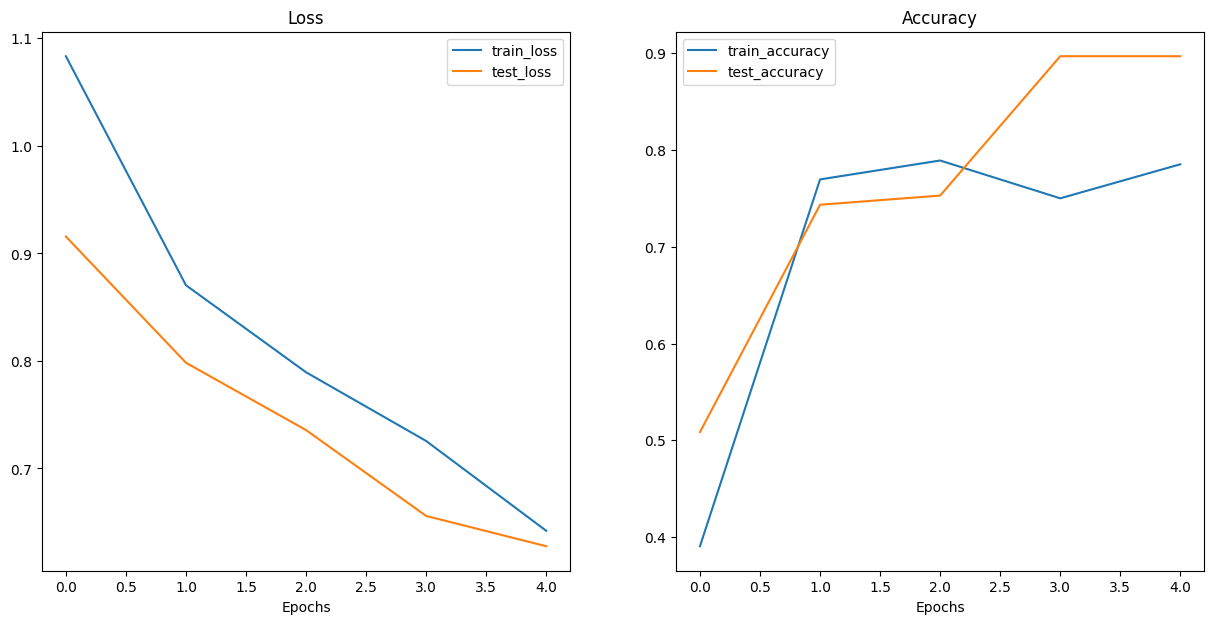

In [155]:
plot_loss_curves(model_0_results)

### 1.5 Make predictions on the entire test dataset with the model

In [13]:
from tqdm.auto import tqdm

def predict(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    device: str,
):
    results = []
    
    # Put model to target device
    model = model.to(device)

    # Turn on eval mode
    model.eval()
    
    # Turn on inference mode
    with torch.inference_mode():
        # Iterate through batches:
        for X, _ in tqdm(dataloader):
            X = X.to(device)
            
            # Create logits
            logits = model(X)
            
            # Transform logits to prediction probabilites
            pred_probs = torch.softmax(logits, dim=1)
            
            # Transform prediction probabilities to labels
            pred_labels = torch.argmax(pred_probs, dim=1)
            
            results.append(pred_labels)
    
    tensor_results = torch.cat(results).cpu()
    
    return tensor_results

In [14]:
preds = predict(
    model=model_0,
    dataloader=test_dataloader,
    device=device,
)

  0%|          | 0/3 [00:00<?, ?it/s]

In [15]:
preds

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2])

In [16]:
len(preds)

75

### 1.6 Make a confusion matrix with the test preds and the truth labels

In [17]:
import torchmetrics, mlxtend

print(mlxtend.__version__)

0.23.4


In [18]:
from torchmetrics import ConfusionMatrix

confmat = ConfusionMatrix(
    num_classes=len(class_names),
    task="multiclass",
)

In [19]:
target = torch.cat(
    [y for _, y in test_dataloader]
)

target

/Users/mchojna/Documents/GitHub/pytorch-course/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])

In [20]:
confmat_tensor = confmat(
    preds=preds,
    target=target
)

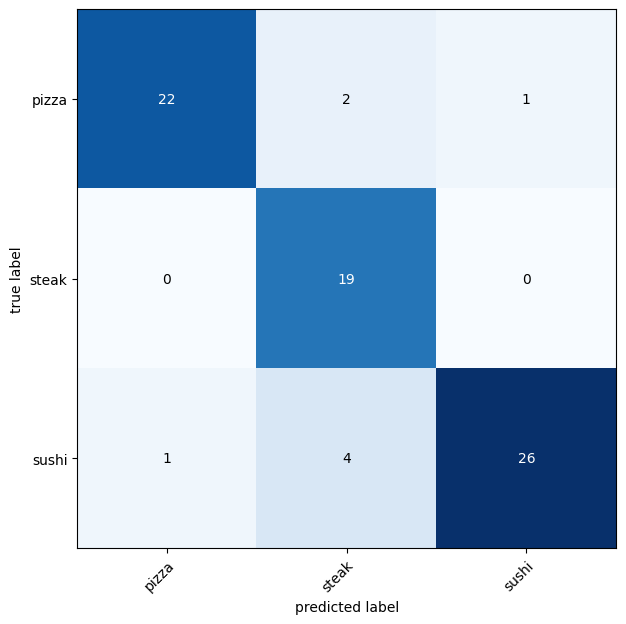

In [21]:
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

In [34]:
from tqdm.auto import tqdm

def predict(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    device: str,
):
    results = {
        "pred_probs": [],
        "pred_labels": []
    }
    
    # Put model to target device
    model = model.to(device)

    # Turn on eval mode
    model.eval()
    
    # Turn on inference mode
    with torch.inference_mode():
        # Iterate through batches:
        for X, _ in tqdm(dataloader):
            X = X.to(device)
            
            # Create logits
            logits = model(X)
            
            # Transform logits to prediction probabilites
            pred_probs = torch.softmax(logits, dim=1)
            
            # Transform prediction probabilities to labels
            pred_labels = torch.argmax(pred_probs, dim=1)
            
            results["pred_probs"].extend(pred_probs.cpu())
            results["pred_labels"].extend(pred_labels.cpu())
        
    return results

In [35]:
results = predict(
    model=model_0,
    dataloader=test_dataloader,
    device=device,
)

/Users/mchojna/Documents/GitHub/pytorch-course/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  0%|          | 0/3 [00:00<?, ?it/s]

In [44]:
import pandas as pd

results_df = pd.DataFrame(
    data=results
)

In [45]:
results_df["pred_probs"] = results_df["pred_probs"].map(
    lambda x: x.max().item()
)

results_df["pred_labels"] = results_df["pred_labels"].map(
    lambda x: x.item()
)

In [49]:
targets = torch.concat([
    y for _, y in test_dataloader
])

targets

/Users/mchojna/Documents/GitHub/pytorch-course/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])

In [53]:
results_df = pd.concat(
    [results_df, pd.Series(targets, name="targets")],
    axis=1
)

In [57]:
results_df["check"] = results_df["pred_labels"] != results_df["targets"]

In [61]:
results_df = results_df[results_df["check"] == True]

In [67]:
sorted_results_df = results_df.sort_values(
    by="pred_probs",
    axis=0,
    ascending=False
)

In [70]:
sorted_results_df = sorted_results_df[:5]

In [71]:
sorted_results_df

,pred_probs,pred_labels,targets,check
70,0.552076,1,2,True
44,0.477743,1,2,True
12,0.435277,1,0,True
57,0.426399,0,2,True
55,0.426231,1,2,True


In [77]:
sorted_results_df.index[0]

np.int64(70)

In [103]:
sorted_results_df.iloc[0, 2]

np.int64(2)

In [75]:
images = torch.concat(
    [X for X, _ in test_dataloader]
)

len(images)

/Users/mchojna/Documents/GitHub/pytorch-course/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


75

In [110]:
std = np.mean(images.numpy())
mean = np.std(images.numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4110641].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.1804092].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].


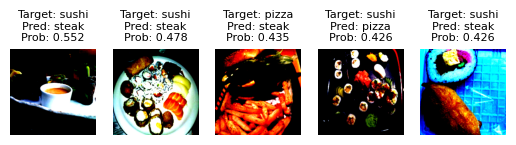

In [116]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.subplot(1, 5, i+1)
    
    img_idx = sorted_results_df.index[i]
    img = images[img_idx].cpu().permute(1, 2, 0).numpy()\
    
    plt.imshow(img)
    
    plt.title(
        f"Target: {class_names[sorted_results_df.iloc[i, 2]]}\nPred: {class_names[sorted_results_df.iloc[i, 1]]}\nProb: {sorted_results_df.iloc[i, 0]:.3f}",
        fontsize=8
    )
    
    plt.axis(False)
plt.show()

## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?

In [143]:
from PIL import Image

images = [
    Image.open(file) for file in [
        "burger.jpg", "fries.jpg", "pizza.jpeg"
    ]
]

In [144]:
images[0].filename

'burger.jpg'

In [145]:
transformed_images = [
    simple_transform(image).unsqueeze(dim=0) for image in images
]

In [146]:
transformed_images[0].shape

torch.Size([1, 3, 224, 224])

In [147]:
model_0.eval()
with torch.inference_mode():
    results = [
        class_names[torch.argmax(torch.softmax(model_0(transformed_image.to(device)), dim=1), dim=1)]
        for transformed_image in transformed_images
    ]

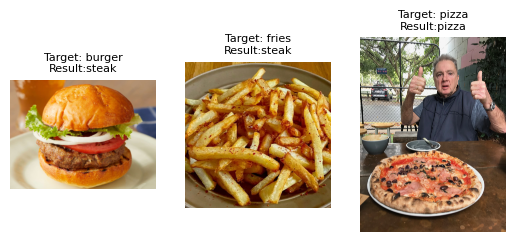

In [148]:
for i in range(len(results)):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i])
    plt.title(
        f"Target: {images[i].filename.split('.')[0]}\nResult:{results[i]}",
        fontsize=8
    )
    plt.axis(False)
plt.show()

## 4. Train the model from section 4  in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?

In [ ]:
model_1 = torchvision.models.efficientnet_b0(
    pretrained=True
).to(device)

for param in model_1.features.parameters():
    param.requires_grad = False
    
torch.manual_seed(42)

output_shape = len(class_names)

model_1.classifier = nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(
        in_features=1280, 
        out_features=output_shape, # same number of output units as our number of classes
        bias=True)

).to(device)

/Users/mchojna/Documents/GitHub/pytorch-course/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mchojna/Documents/GitHub/pytorch-course/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [151]:
# Define loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model_1.parameters(),
    lr=0.001,
)

# Set the random seeds
torch.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
model_1_results = engine.train(model=model_1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=20,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

/Users/mchojna/Documents/GitHub/pytorch-course/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch: 1 | train_loss: 1.0834 | train_acc: 0.3906 | test_loss: 0.9157 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8704 | train_acc: 0.7695 | test_loss: 0.7983 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7895 | train_acc: 0.7891 | test_loss: 0.7357 | test_acc: 0.7528
Epoch: 4 | train_loss: 0.7256 | train_acc: 0.7500 | test_loss: 0.6558 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.6420 | train_acc: 0.7852 | test_loss: 0.6277 | test_acc: 0.8968
Epoch: 6 | train_loss: 0.6060 | train_acc: 0.7891 | test_loss: 0.5626 | test_acc: 0.9072
Epoch: 7 | train_loss: 0.5121 | train_acc: 0.9141 | test_loss: 0.5397 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.5769 | train_acc: 0.8125 | test_loss: 0.5382 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.5747 | train_acc: 0.8125 | test_loss: 0.4992 | test_acc: 0.9176
Epoch: 10 | train_loss: 0.4639 | train_acc: 0.9297 | test_loss: 0.4250 | test_acc: 0.8759
Epoch: 11 | train_loss: 0.4650 | train_acc: 0.8867 | test_loss: 0.4328 | test_acc: 0.9176
Epoch: 12 | train_l

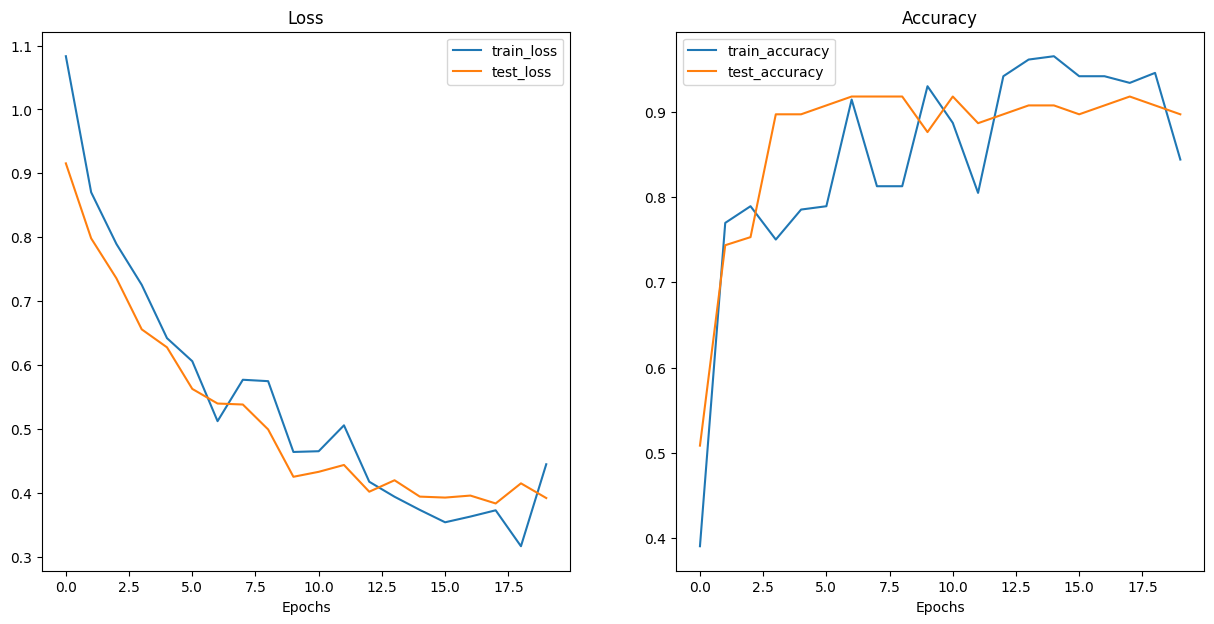

In [156]:
plot_loss_curves(model_1_results)

## 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.

In [158]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

### 5.1 Create DataLoaders

In [163]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [164]:
train_dataloader_20_percent, test_dataloader_20_percent, class_names = setup_data.create_dataloaders(
    train_dir=train_dir_20_percent,
    test_dir=test_dir_20_percent,
    transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
    batch_size=32 # set mini-batch size to 32
)
len(train_dataloader_20_percent), len(test_dataloader_20_percent), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 5.2 Get a pretrained model

In [174]:
model_2 = torchvision.models.efficientnet_b0(
    pretrained=True,
).to(device)

/Users/mchojna/Documents/GitHub/pytorch-course/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mchojna/Documents/GitHub/pytorch-course/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [175]:
for param in model_2.features.parameters():
    param.requires_grad = False

In [176]:
output_shape = len(class_names)

model_2.classifier = nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(
        in_features=1280, 
        out_features=output_shape, # same number of output units as our number of classes
        bias=True)

).to(device)

In [177]:
# Define loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model_1.parameters(),
    lr=0.001,
)

# Set the random seeds
torch.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
model_2_results = engine.train(
    model=model_2,
    train_dataloader=train_dataloader_20_percent,
    test_dataloader=test_dataloader_20_percent,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=20,
    device=device
)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

/Users/mchojna/Documents/GitHub/pytorch-course/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch: 1 | train_loss: 1.1383 | train_acc: 0.2958 | test_loss: 1.1313 | test_acc: 0.3557
Epoch: 2 | train_loss: 1.1252 | train_acc: 0.3521 | test_loss: 1.1220 | test_acc: 0.3523
Epoch: 3 | train_loss: 1.1396 | train_acc: 0.3021 | test_loss: 1.1200 | test_acc: 0.3676
Epoch: 4 | train_loss: 1.1502 | train_acc: 0.2562 | test_loss: 1.1222 | test_acc: 0.3528
Epoch: 5 | train_loss: 1.1271 | train_acc: 0.3479 | test_loss: 1.1269 | test_acc: 0.3648
Epoch: 6 | train_loss: 1.1326 | train_acc: 0.3729 | test_loss: 1.1248 | test_acc: 0.3341
Epoch: 7 | train_loss: 1.1390 | train_acc: 0.3063 | test_loss: 1.1160 | test_acc: 0.3528
Epoch: 8 | train_loss: 1.1364 | train_acc: 0.3063 | test_loss: 1.1204 | test_acc: 0.3710
Epoch: 9 | train_loss: 1.1253 | train_acc: 0.3708 | test_loss: 1.1245 | test_acc: 0.3767
Epoch: 10 | train_loss: 1.1301 | train_acc: 0.3521 | test_loss: 1.1266 | test_acc: 0.3489
Epoch: 11 | train_loss: 1.1289 | train_acc: 0.3146 | test_loss: 1.1234 | test_acc: 0.3739
Epoch: 12 | train_l

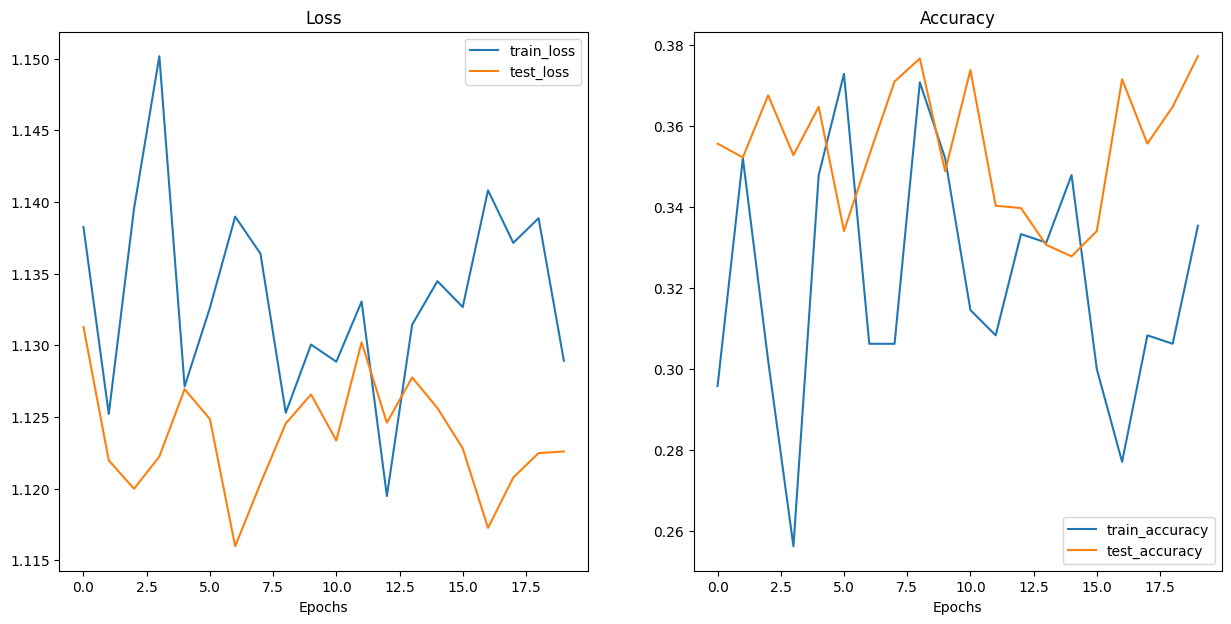

In [178]:
plot_loss_curves(model_2_results)

## 6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?

In [192]:
model_3 = torchvision.models.efficientnet_b7(
    pretrained=True,
).to(device)

/Users/mchojna/Documents/GitHub/pytorch-course/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mchojna/Documents/GitHub/pytorch-course/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [193]:
from torchinfo import summary

summary(model_3)

Layer (type:depth-idx)                                  Param #
EfficientNet                                            --
├─Sequential: 1-1                                       --
│    └─Conv2dNormActivation: 2-1                        --
│    │    └─Conv2d: 3-1                                 1,728
│    │    └─BatchNorm2d: 3-2                            128
│    │    └─SiLU: 3-3                                   --
│    └─Sequential: 2-2                                  --
│    │    └─MBConv: 3-4                                 4,944
│    │    └─MBConv: 3-5                                 1,992
│    │    └─MBConv: 3-6                                 1,992
│    │    └─MBConv: 3-7                                 1,992
│    └─Sequential: 2-3                                  --
│    │    └─MBConv: 3-8                                 21,224
│    │    └─MBConv: 3-9                                 38,700
│    │    └─MBConv: 3-10                                38,700
│    │    └─MBConv: 3-1

In [194]:
for param in model_3.features.parameters():
    param.requires_grad = False

In [195]:
model_3.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=True)
  (1): Linear(in_features=2560, out_features=1000, bias=True)
)

In [196]:
output_shape = len(class_names)

model_3.classifier = nn.Sequential(
    torch.nn.Dropout(p=0.5, inplace=True),
    torch.nn.Linear(
        in_features=2560, 
        out_features=output_shape, # same number of output units as our number of classes
        bias=True)

).to(device)

In [197]:
# Define loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model_3.parameters(),
    lr=0.001,
)

# Set the random seeds
torch.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
model_3_results = engine.train(
    model=model_3,
    train_dataloader=train_dataloader_20_percent,
    test_dataloader=test_dataloader_20_percent,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=20,
    device=device
)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

/Users/mchojna/Documents/GitHub/pytorch-course/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch: 1 | train_loss: 0.9980 | train_acc: 0.5437 | test_loss: 0.8508 | test_acc: 0.7710
Epoch: 2 | train_loss: 0.8111 | train_acc: 0.7396 | test_loss: 0.6735 | test_acc: 0.8614
Epoch: 3 | train_loss: 0.6949 | train_acc: 0.8187 | test_loss: 0.5403 | test_acc: 0.8983
Epoch: 4 | train_loss: 0.5455 | train_acc: 0.8896 | test_loss: 0.4605 | test_acc: 0.9136
Epoch: 5 | train_loss: 0.5373 | train_acc: 0.8500 | test_loss: 0.4122 | test_acc: 0.9199
Epoch: 6 | train_loss: 0.4844 | train_acc: 0.8771 | test_loss: 0.3825 | test_acc: 0.9045
Epoch: 7 | train_loss: 0.4727 | train_acc: 0.8750 | test_loss: 0.3636 | test_acc: 0.9074
Epoch: 8 | train_loss: 0.4556 | train_acc: 0.8708 | test_loss: 0.3569 | test_acc: 0.8949
Epoch: 9 | train_loss: 0.4246 | train_acc: 0.8604 | test_loss: 0.3538 | test_acc: 0.8949
Epoch: 10 | train_loss: 0.3809 | train_acc: 0.8896 | test_loss: 0.3598 | test_acc: 0.9040
Epoch: 11 | train_loss: 0.3978 | train_acc: 0.8875 | test_loss: 0.3638 | test_acc: 0.8886
Epoch: 12 | train_l

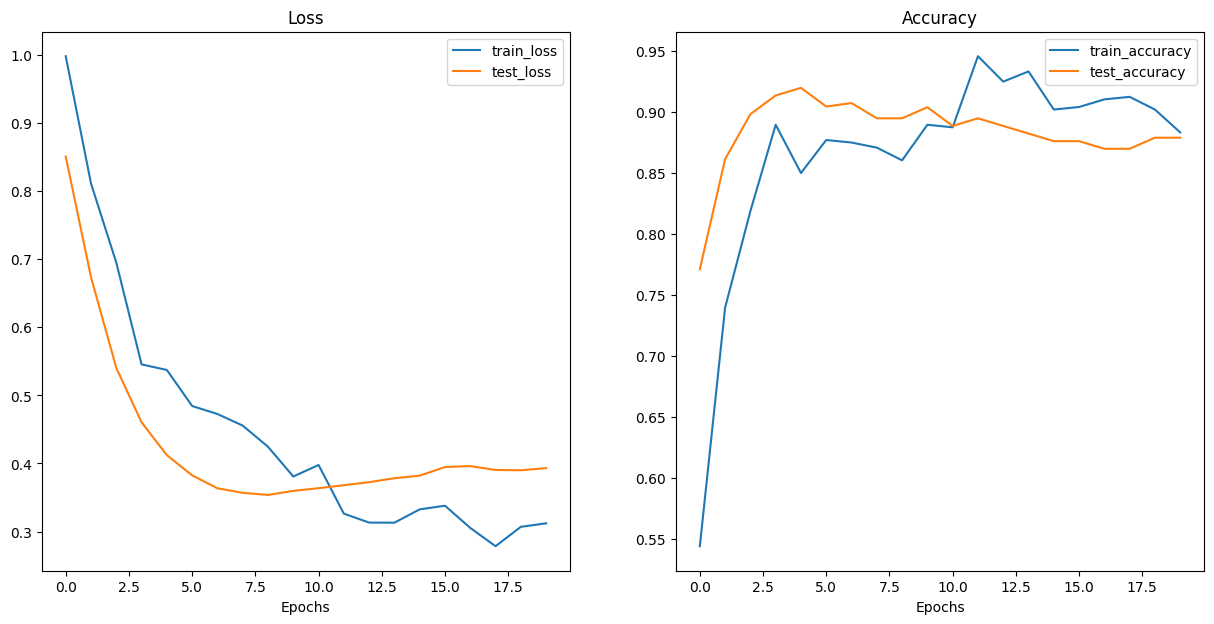

In [198]:
plot_loss_curves(model_3_results)